# Digitale Zaubertinte: Steganography workshop

**Author:** Martin Beneš, Verena Lachner

<div style="text-align: center">
<a href="https://www.github.com/uibk-uncover/mip-stego-demo">
github.com/uibk-uncover/mip-stego-demo
</a>
</div>

## Notebook setup

For this notebook, we will use a sample image `00001.tif` from ALASKA database. Run following code chunk to download it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.stats
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.set_printoptions(threshold=99)
plt.rcParams["figure.figsize"] = (12, 3)
np.random.seed(12345)

In [2]:
# download nockspitze from GitHub
import requests
res = requests.get(f'https://github.com/uibk-uncover/mip-stego-demo/raw/main/img/nockspitze.png')
with open('nockspitze.png', 'wb') as f:
    f.write(res.content)

In [3]:
def lsbr(x: np.ndarray, alpha: float = 1., method: str = 'permuted', seed: int = 12345) -> np.ndarray:
    """This function simulates LSB replacement."""
    # probability
    if method == 'sequential':
        payload = int(np.ceil(alpha * x.size))
        probability = np.reshape([1/2.]*payload + [0]*(x.size - payload), x.shape)
    elif method == 'permuted':
        probability = np.ones(x.shape, dtype='float64') * alpha / 2
    else:
        raise NotImplementedError(f'unknown method {method}')
    # simulate
    rng = np.random.default_rng(seed)
    to_be_changed = rng.random(x.shape) < probability
    # modify
    y = np.copy(x)
    y[to_be_changed & (x % 2 == 0)] += 1
    y[to_be_changed & (x % 2 != 0)] -= 1
    return y

<center><h2>Let's play a coin game!</h2></center>

$1000$ people toss a coin $100$ times, and count heads.

In [4]:
import numpy as np
toss = np.random.choice([0, 1], size=[1000, 100])  # toss
toss_sums = np.sum(toss, axis=1)  # count heads

Function `np.random.choice` chooses at random an element from $\{0,1\}$ (where 1 represents head). This is repeated $1000\cdot100\times$ and the results are aligned in 2D matrix.

In [5]:
toss

array([[0, 1, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 1, 1, 0]])

In [6]:
toss.shape

(1000, 100)

Then, we sum the number of ones in each column, i.e. along axis 1. We get a vector with $1000$ elements.

In [7]:
toss_sums

array([56, 50, 46, ..., 51, 44, 51])

For a fair coin, we expect the sum to be around $50$.

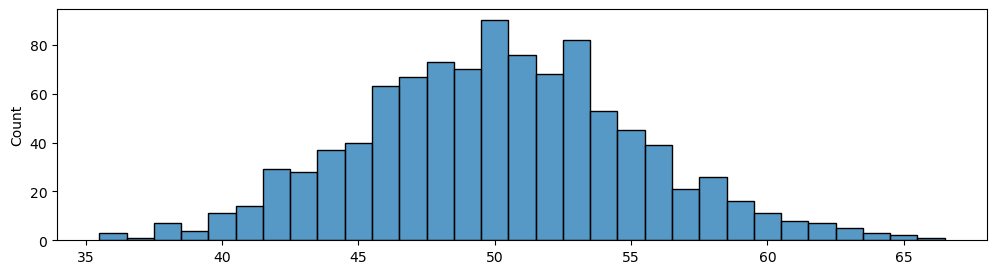

In [8]:
import seaborn as sns
sns.histplot(toss_sums, discrete=True);  # plot histogram

Histograms allows us to analyze data distribution graphically.

<center><h2>Playing with unfair coin</h2></center>

We repeat the experiment, now with an unfair coin.

Our unfair coin yields heads with a probability $52\%$.

In [9]:
toss2 = np.random.choice([0, 1], size=[1000, 100], p=[.48, .52])
toss2_sums = np.sum(toss2, axis=1)

The probabilities of each element from $\{0,1\}$ are specified by an additional parameter `p`.

The probability of head ($1$) is $0.52$, i.e., $52\%$.

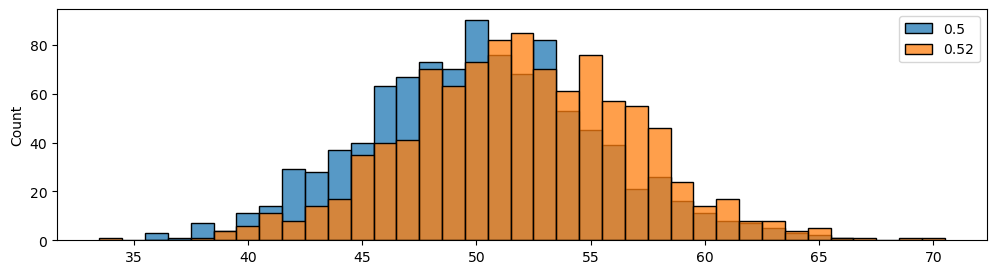

In [10]:
sns.histplot(toss_sums, discrete=True, label='0.5');  # fair
sns.histplot(toss2_sums, discrete=True, label='0.52');  # unfair
plt.legend();

Is the orange histogram same as the blue one?

It is not an easy answer. The average looks a bit higher, but the draws are pretty much in the same range.

We can test it using statistics.

$\chi^2$ test compares the shapes of two histograms, $h$ and $g$.

$$X^2=\sum_{i=1}^{N}\frac{(h_i - g_i)^2}{h_i}$$

We combine the corresponding bins of the two histograms using the fraction inside the sum.

Then, the results are summed over all the bins.

In [11]:
# histograms
h = np.histogram(toss_sums, bins=range(100+1))[0]
g = np.histogram(toss2_sums, bins=range(100+1))[0]

# test statistics
test_stat = 0
for i in range(100):
    if h[i] > 0:
        test_stat += (h[i] - g[i])**2 / h[i]

`np.histogram` computes the histogram. The `for` loop implements the $\chi^2$-test formula above.

In [12]:
test_stat  # test statistic

197.7241088701197

We get a test statistic. The higher the number, the bigger difference between the histograms.

We convert the test statistic to p-value (using $\chi^2$ distribution).

In [13]:
scipy.stats.chi2.sf(test_stat, 100-1)  # significant if <0.05

1.4826819136900469e-08

Unlike the test statistic, the p-value accounts for number of samples we observe.

We can interpret p-value directly. If the p-value is below $0.05$, the difference between the histograms is statistically significant.

The histograms are different. **Something's wrong with the coin!**

<center><h2>Enough of coins, back to images!</h2></center>

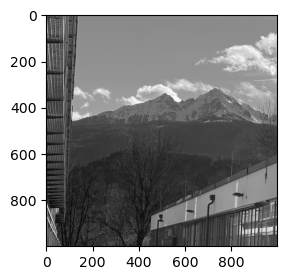

In [14]:
# load image
x = np.array(Image.open('nockspitze.png').convert('L'))
plt.imshow(x,cmap = "gray");

We create a histogram of the test cover image. Recall that image pixels contain values $0-255$.

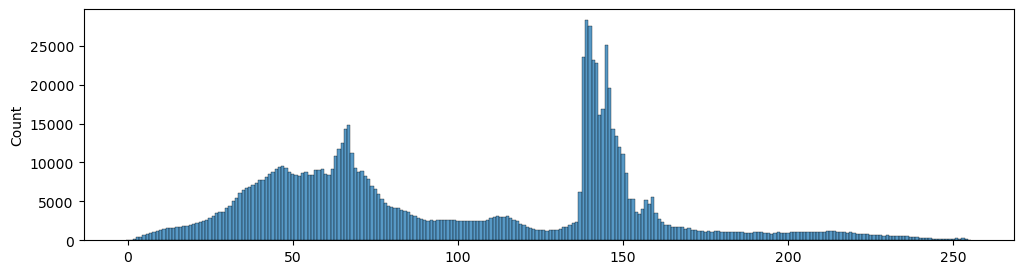

In [15]:
sns.histplot(x.flatten(), discrete=True);  # cover histogram

We can also embed LSB replacement into the image, and look at the stego histogram.

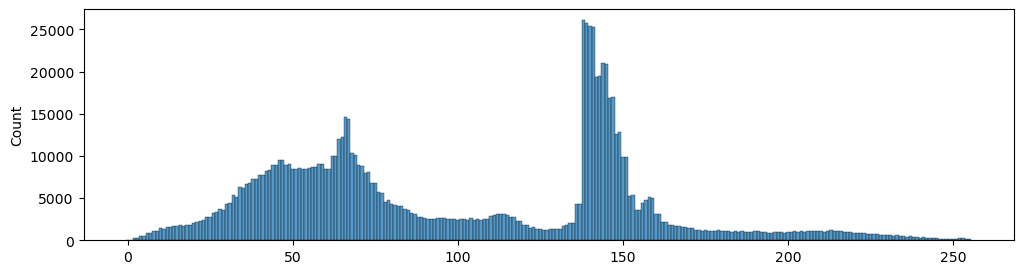

In [16]:
sns.histplot(lsbr(x, 1.).flatten(), discrete=True);  # stego histogram

Let's take a closer look. What is going on with the histogram?

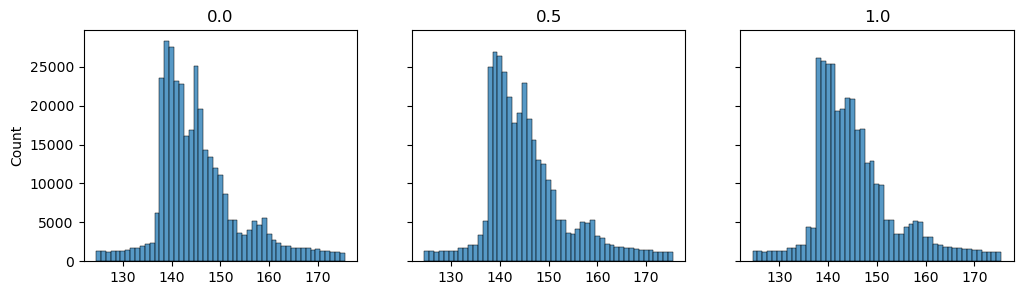

In [17]:
fig, ax = plt.subplots(1, 3, sharey=True)
for i, alpha in enumerate([.0, .5, 1.]):
    y = lsbr(x, alpha).flatten()
    sns.histplot(y, binrange=(125, 175), discrete=True, ax=ax[i]);
    ax[i].set_title(f'{alpha:.1f}');

LSBr averages the neighbor pairs (even and odd neighbor).

$$\bar{h}_i=\frac{h_{i}+h_{i+1}}{2}$$

In [18]:
# histogram
h, edges = np.histogram(x.flatten(), bins=range(256+1))
# average even-odd pairs
hbar = np.repeat((h[:-1:2] + h[1::2]) / 2, 2)

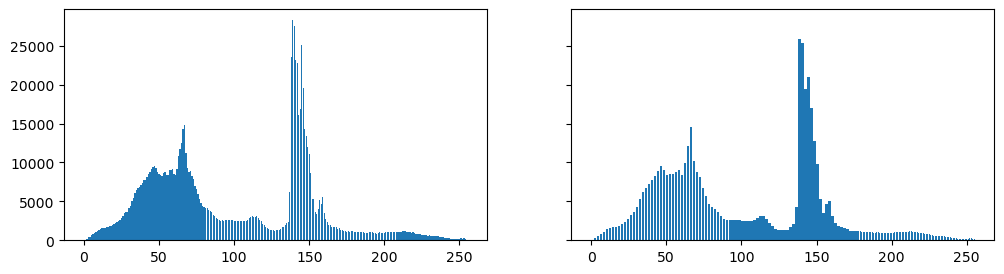

In [19]:
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].bar(range(256), h);
ax[1].bar(range(256), hbar);

Can we use $\chi^2$ test to detect steganography?

We can test the difference between the histogram, and its pair average.

If the histogram is similar to the pair-averaged histogram, steganography is present.

$$S=\sum_{i=0}^{255}\frac{(h_i-\bar{h}_i)^2}{\bar{h}_i}$$

$h$ is the histogram of the analyzed image. We construct $\bar{h}$ from $h$ by averaging its neighbors. Compare the formula with the one we used for fair vs. unfair coin.

In [20]:
# Avoid division by zero
h = h[hbar > 0]
hbar = hbar[hbar > 0]
# Chi2 test
test_stat = np.sum((h - hbar)**2 / hbar)
pvalue = scipy.stats.chi2.sf(test_stat, 2**8-1)

We replaced the `for` loop with a on-liner, which is shorter, faster, and in this case closer to the formula.

In the p-value calculation, we specify $2^8-1=255$ degrees of freedom.

In [21]:
pvalue  # stego if >0.05

0.0

If the histogram is close to the pair-averaged histogram, the image contains LSBr steganography.

They are the same, if p-value is greater than $5\%$.

P-value is less than $5\%$, histograms are different. The image is **cover**.

We run the $\chi^2$-test for stego.

In [22]:
def chi2_attack(x):
    # histograms
    h = np.histogram(x.flatten(), bins=range(256+1))[0]
    hbar = np.repeat((h[:-1:2] + h[1::2])/2, 2)
    h, hbar = h[hbar > 0], hbar[hbar > 0]
    # chi2 test
    S = np.sum((h[:-1:2] - hbar[::2])**2 / hbar[::2])
    return scipy.stats.chi2.sf(S, h.size-1)

In [23]:
y = lsbr(x, 1.)  # create stego
pvalue = chi2_attack(y)  # chi2 attack

In [24]:
pvalue  # stego if >0.05

1.0

P-value is greater than $5\%$, histograms are the same. The image is **stego**.

## Take-away messages

- Steganography distorts image statistics.

- $\chi^2$ test can detect the presence of LSB replacement steganography.

## Hands-on: LSBr

- Find the image(s) with steganography among the suspicious images
- Try to extract the messages
  - The secret key is *the answer to life, the universe, and everything*. (Maybe Google can help you with that)


First, we download the suspicious images from the server.

They are called `nockspitze.png`, `statue.png`, and `martinswand.png`.

In [25]:
# download suspicious images
import requests
for fname in ['t21a.png', 'statue.png', 'martinswand.png']:
    res = requests.get(f'https://github.com/uibk-uncover/mip-stego-demo/raw/main/img/{fname}')
    with open(fname, 'wb') as f:
        f.write(res.content)

For the extraction, you might find following function useful.

In [26]:
import zlib
def extract_lsbr(stego: np.ndarray, key: int = None) -> str:
    # permuted walk-through
    perm = np.linspace(0, stego.size-1, stego.size, dtype='int64')
    if key is not None:
        rng = np.random.default_rng(key)
        perm = rng.permutation(perm)

    # Gather LSB bits along pseudorandom path
    message_bits_extracted = []
    for i, it in enumerate(perm):
        # get index (x- and y-coordinate)
        idx = it // stego.shape[1], it % stego.shape[1]

        # get message bit
        message_bits_extracted.append(stego[idx] & 1)

    # convert to bytes
    message_bytes_extracted = b''
    for i in range(len(message_bits_extracted)//8):
        char_bits = list(message_bits_extracted[i*8:(i+1)*8])

        # decode the byte
        byte = 0
        for i, bit in enumerate(char_bits):
            byte |= bit << i
        message_bytes_extracted += int(byte).to_bytes(1, byteorder='big')

    # unzip the message
    message = zlib.decompressobj().decompress(message_bytes_extracted)
    return message.decode('ascii')

Unlike in the exercise 2, here we zip the message, in order to

- reduce its size, and
- increase its entropy (each bit carries more information)

First you load the images into Python.

In [27]:
# load suspicious images
t21a = np.array(Image.open(f't21a.png'))
martinswand = np.array(Image.open(f'martinswand.png'))
statue = np.array(Image.open(f'statue.png'))

Run $\chi^2$ test on each image.

In [28]:
chi2_attack(t21a)

0.0

In [29]:
chi2_attack(statue)

0.0

In [30]:
chi2_attack(martinswand)

1.0

Try to extract the message from the suspicious image. The key, *the answer to life, the universe and everything*, is 42.

In [31]:
key = 42  # answer to life
message = extract_lsbr(martinswand, key=key)

In [32]:
print(message[:300], '...')


1609

THE SONNETS

by William Shakespeare



                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as the riper should by time decease,
  His tender heir might bear his memory:
  But thou contracted to thine own bright eyes,
  Feed's ...


It's Shakespeare's work!

In [33]:
print(extract_lsbr(t21a))  # hidden Easter egg

Hi Verena!
Sorry again that you lost the key from your bike.
Let's meet today by the bike stand to cut the lock.

Martin.


So Martin and Verena aren't guilty afterall.